In [1]:
from rtlsdr import RtlSdr 
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision = 2)

In [2]:
try: 
    sdr.close()
    print("Closed old SDR")
except NameError:
   print("No SDR instance found")

No SDR instance found


In [3]:
sdr = RtlSdr()

### Data Collection

In [4]:
fsps = 3200000      # 1         Msps
fc = 848.8e6        # 849.115   MHz
bitrate = 2e3       # .1        ksps

dt = 1.0 / fsps
nyquist = fsps / 2.0
Tmax = 0.5
N = round(fsps * Tmax)

bitperiod = 1 / bitrate
sampsperbit = round(fsps / bitrate)

sdr.sample_rate = fsps 
sdr.center_freq = fc
sdr.gain = 25

print("sample size is ", N)
print("sampling rate is ", fsps)
print("center frequency is ", fc)

sample size is  1600000
sampling rate is  3200000
center frequency is  848800000.0


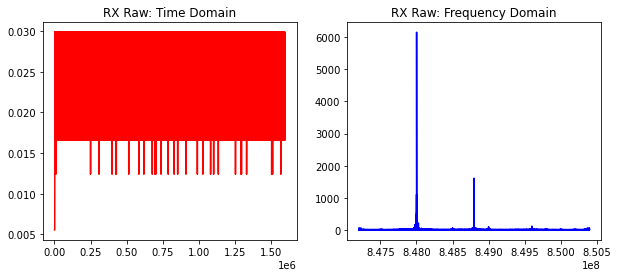

In [5]:
samples = sdr.read_samples(N)

spectrum = np.fft.fftshift(np.fft.fft(samples))
freqs = np.linspace(fc-nyquist,fc+nyquist,len(spectrum))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.set_title("RX Raw: Time Domain")
ax1.plot(np.abs(samples), color='red')
ax2.set_title("RX Raw: Frequency Domain")
ax2.plot(freqs, np.abs(spectrum), color='blue')

### Downconversion

(0.0, 10000.0)

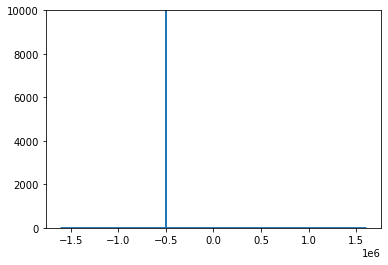

In [6]:
t = np.arange(0, N)
dfc = 500e3 # 0.315MHz
freqs = np.linspace(-nyquist,+nyquist,len(spectrum))
dsinusoid = np.exp(-2j*np.pi*t*dfc/fsps)
plt.plot(freqs, np.abs(np.fft.fftshift(np.fft.fft(dsinusoid))))
plt.ylim(0, 10000)

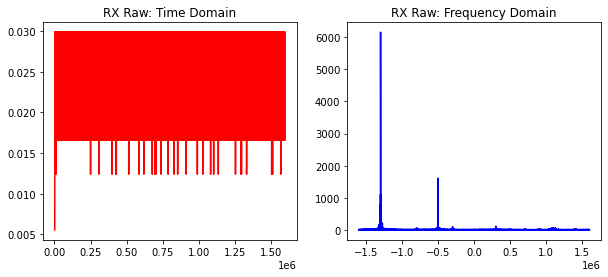

In [7]:
dsamples = dsinusoid * samples
dspectrum = np.fft.fftshift(np.fft.fft(dsamples))
freqs = np.linspace(-nyquist,+nyquist,len(dspectrum))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.set_title("RX Raw: Time Domain")
ax1.plot(np.abs(dsamples), color='red')
ax2.set_title("RX Raw: Frequency Domain")
ax2.plot(freqs, np.abs(dspectrum), color='blue')

### Filter Raw I/Q Data

In [8]:
def bandpassmask(N, fsps, fcutoff):
    fnyq = fsps / 2.0
    fcutoff_nyq = fcutoff / fnyq 
    midwidth = round(fcutoff_nyq*N)
    zerowidth = int((N-midwidth)/2)
    res = np.concatenate((np.zeros(zerowidth),np.ones(midwidth),np.zeros(zerowidth)))
    res = np.concatenate((res, np.zeros(N - len(res))))
    return(res)

def squelch(signal, p):
    abs = np.abs(signal)
    threshold = np.ptp(abs) * p
    res = np.copy(signal)
    for i in range(len(signal)):
        if (abs[i] > threshold):
            res[i] = 0.0
    return res

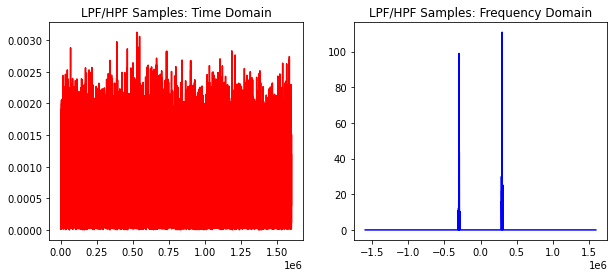

In [9]:
# lpf/hpf filtering
lpf = 0.31e6
hpf = 0.29e6
fspectrum = dspectrum  * (1 - bandpassmask(N, fsps, hpf)) * bandpassmask(N, fsps,lpf)
fsamples = np.fft.ifft(np.fft.fftshift(fspectrum))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.set_title("LPF/HPF Samples: Time Domain")
ax1.plot(np.abs(fsamples), color='red')
ax2.set_title("LPF/HPF Samples: Frequency Domain")
ax2.plot(freqs, np.abs(fspectrum), color='blue')

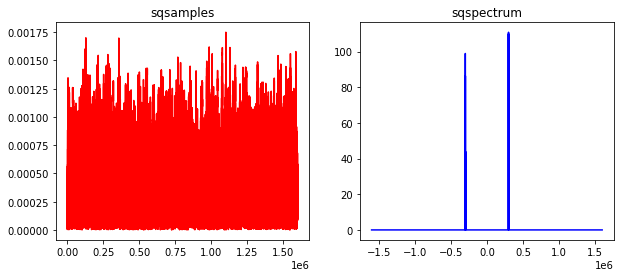

In [10]:
# squelching
sqspectrum = fspectrum - squelch(fspectrum, 0.3)
sqsamples = np.fft.ifft(np.fft.fftshift(sqspectrum))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.set_title("sqsamples")
ax1.plot(np.abs(sqsamples), color='red')
ax2.set_title("sqspectrum")
ax2.plot(freqs, np.abs(sqspectrum), color='blue')

### Decimation

In [11]:
# # decimation filtering
# dec_factor = 1 # sampsperbit // 100 # we want 100 dec_sampsperbit
# dec_sampsperbit = sampsperbit // dec_factor
# dec_fsps = fsps // dec_factor
# dec_nyquist = dec_fsps // 2
# dec_N = N // dec_factor

# dec_cdtheta = filteredsignal[::dec_factor]
# dec_cdtheta_spectrum = np.fft.fftshift(np.fft.fft(dec_cdtheta))
# dec_freqs = np.linspace(fc-dec_nyquist, fc+dec_nyquist, dec_N)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
# ax1.set_title("dec_cdtheta: Time Domain")
# ax1.plot(dec_cdtheta, color='red')
# ax2.set_title("dtheta: Frequency Domain")
# ax2.plot(dec_freqs, np.abs(dec_cdtheta_spectrum), color='blue')

### Extract Instantaneous Frequency

In [12]:
filteredsignal = fsamples

In [13]:
# compute theta
theta = np.arctan2(filteredsignal.imag, filteredsignal.real)

In [14]:
# compute phase derivative (= frequency) with 0, +pi comparison method
derivthetap0 = np.convolve([1,-1], theta,'same')
derivthetapp = np.convolve([1,-1], (theta+np.pi) % (2*np.pi),'same')
derivtheta = np.zeros(len(derivthetap0))
for i in range(len(derivthetap0)):
    if (abs(derivthetap0[i]) < abs(derivthetapp[i])):
        derivtheta[i] = derivthetap0[i] 
    else:
        derivtheta[i] = derivthetapp[i] 

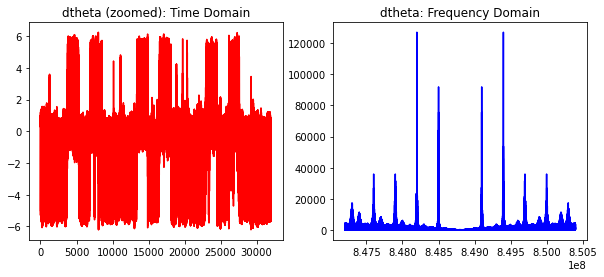

In [15]:
spectrum = np.fft.fftshift(np.fft.fft(derivtheta))
freqs = np.linspace(fc-nyquist, fc+nyquist, N)

a = sampsperbit*20
b = sampsperbit*40
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.set_title("dtheta (zoomed): Time Domain")
ax1.plot(derivtheta[a:b], color='red')
ax2.set_title("dtheta: Frequency Domain")
ax2.plot(freqs, np.abs(spectrum), color='blue')

### Filter Frequency Data

In [16]:
def smooth(derivtheta, win):
    cdtheta = np.copy(derivtheta)
    spikethresh = 0.5
    for i in range(win, len(derivtheta)-win):
        if (abs(derivtheta[i])>spikethresh):
            cdtheta[i] = np.mean(derivtheta[i-win:i+win])/(2*win)
    return cdtheta

In [17]:
# remove spikes
cdtheta = smooth(derivtheta, 64)

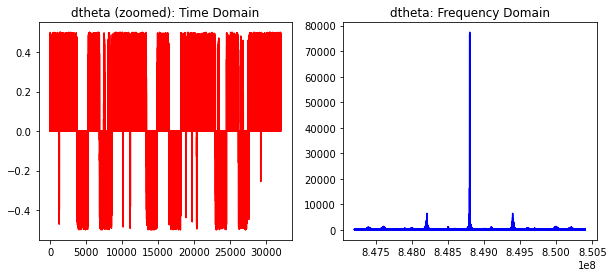

In [18]:
spectrum = np.fft.fftshift(np.fft.fft(cdtheta))
freqs = np.linspace(fc-nyquist, fc+nyquist, N)

a = sampsperbit*20
b = sampsperbit*40
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.set_title("dtheta (zoomed): Time Domain")
ax1.plot(cdtheta[a:b], color='red')
ax2.set_title("dtheta: Frequency Domain")
ax2.plot(freqs, np.abs(spectrum), color='blue')

### Demodulate

In [19]:
def convolve_with_tophat(input_array, tophat_length):
    n = len(input_array)
    m = tophat_length
    tophat = np.ones(m) / m
    padded_array = np.pad(input_array, (m // 2, m // 2), mode='constant')
    result = np.zeros(n)
    for i in range(n):
        result[i] = np.sum(padded_array[i:i+m] * tophat)
    return result

In [20]:
dem = cdtheta

In [21]:
sampsperbit

1600

In [22]:
# match filtering
dem_mf = convolve_with_tophat(dem, round(sampsperbit * 0.75))
dem_sign = np.sign(dem_mf)

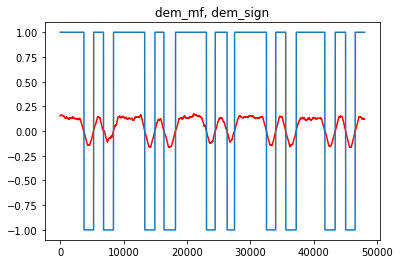

In [23]:
a = 20 * sampsperbit
b = 50 * sampsperbit
plt.title("dem_mf, dem_sign")
# plt.plot(dem[a:b])
plt.plot(dem_mf[a:b], color='red')
plt.plot(dem_sign[a:b])

In [27]:
# edge detection
win = 10
edge = win
while edge < len(dem_sign) - win:
    if np.abs(np.mean(dem_sign[edge - win:edge]) - np.mean(dem_sign[edge:edge + win])) > 1:
        break
    edge += 1

if (edge == len(dem_sign)):
    print("No edge found.")

print("edge: %d" % edge)

edge: 757


In [28]:
#sample bits
rxdata = np.array([])
i = edge + sampsperbit // 2
print(i)
while i < len(dem_sign):
    rxdata = np.concatenate((rxdata, np.array([dem_sign[i]])))
    i += sampsperbit
rxdata = (rxdata + 1) / 2


1557


In [30]:
print(rxdata)

[0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1.
 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1.
 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1.
 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0.
 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0.
 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0.
 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0.
 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1.
 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1.
 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1.
 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1.
 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1.

### Channel Decoding

# TODO